[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 2006, number of used features: 22
[LightGBM] [Info] Start training from score -0.434013
Adjusting learning rate to 0.1
Adjusting learning rate to 0.09000000000000001
Adjusting learning rate to 0.08100000000000002
Adjusting learning rate to 0.0729
Adjusting learning rate to 0.06561
Adjusting learning rate to 0.05904900000000001
Adjusting learning rate to 0.05314410000000001
Adjusting learning rate to 0.04782969000000001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

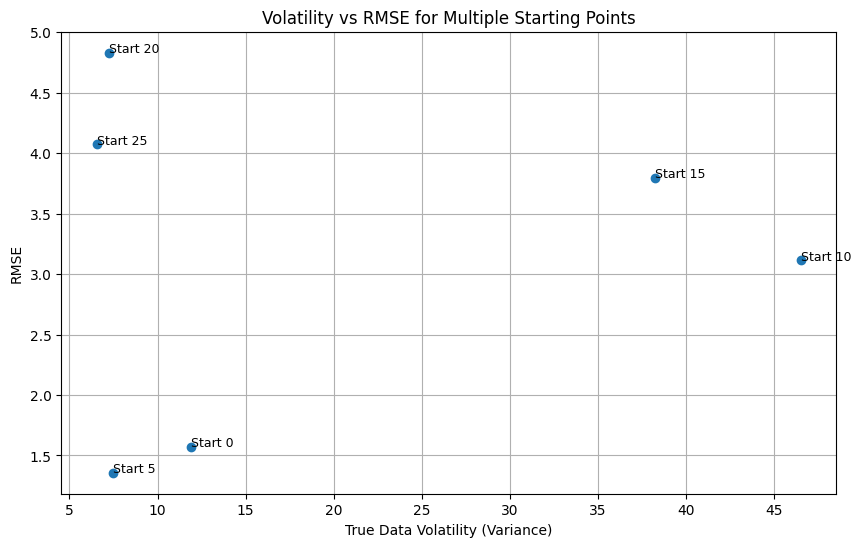

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb  # Importing LightGBM

# Function to create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)  # Percentage change
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Function to split the dataset
def split_data(df, training_period, train_ratio=0.8):
    # Create lag features and rolling statistics
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)  # Remove rows with NaN values

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=['Close']).columns, index=df.index)
    scaled_data['Close'] = df['Close']  # Keep original target for splitting

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data['Close'] = target_scaler.fit_transform(df['Close'].values.reshape(-1, 1)).ravel()

    # Split data
    split_idx = int(len(df) * train_ratio)
    train_data = scaled_data.iloc[:split_idx]
    test_data = scaled_data.iloc[split_idx:]

    # Separate features and targets
    X_train = train_data.drop(columns=['Close'])
    y_train = train_data['Close']
    X_test = test_data.drop(columns=['Close'])
    y_test = test_data['Close']

    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

# Function to apply learning rate scheduler during training
def train_lightgbm_with_scheduler(X_train, y_train, initial_lr=0.1, decay_rate=0.9, num_boost_round=100):
    # Define the LightGBM model
    model = lgb.LGBMRegressor(
        n_estimators=num_boost_round,
        max_depth=15,
        random_state=42,
        learning_rate=initial_lr
    )

    # Callback to decay the learning rate after each round
    def learning_rate_scheduler(env):
        # Decay learning rate every 10 iterations
        if env.iteration % 10 == 0:
            new_lr = initial_lr * (decay_rate ** (env.iteration // 10))
            print(f"Adjusting learning rate to {new_lr}")
            model.set_params(learning_rate=new_lr)

    # Train the model with the scheduler
    model.fit(X_train, y_train, callbacks=[learning_rate_scheduler])
    
    return model

# Function to evaluate and visualize predictions for multiple starting points
def evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler):
    errors = []
    volatilities = []

    start_indices = range(0,30, 5)
    for start_idx in start_indices:
        end_idx = start_idx + n_days_to_predict

        # Ensure the model always gets the past 15 days of data
        context_idx = start_idx - 15
        X_context = X_test.iloc[context_idx:start_idx]  # Past 15 days
        X_sub = X_test.iloc[start_idx:end_idx]
        y_true = y_test.iloc[start_idx:end_idx]

        # Predict and invert scaling for the target
        predictions = model.predict(X_sub)
        predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).ravel()
        y_true_unscaled = target_scaler.inverse_transform(y_true.values.reshape(-1, 1)).ravel()

        # Calculate RMSE
        rmse = math.sqrt(mean_squared_error(y_true_unscaled, predictions))
        errors.append(rmse)

        # Calculate variance of true values
        true_volatility = y_true_unscaled.var()
        volatilities.append(true_volatility)

        # Plot predictions
        plt.figure(figsize=(10, 6))
        plt.plot(test_index[start_idx:end_idx], y_true_unscaled, label="True Data", color="green")
        plt.plot(test_index[start_idx:end_idx], predictions, label="Predictions", color="orange")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"Predictions from Index {start_idx} to {end_idx}")
        plt.legend()
        os.makedirs("TSLA_pred/lightgbm/80_20", exist_ok=True)
        plt.savefig(f"TSLA_pred/lightgbm/80_20/start_{start_idx}.png")
        plt.close()

    # Plot volatility vs errors
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, errors, marker="o")
    for i, idx in enumerate(start_indices):
        plt.text(volatilities[i], errors[i], f"Start {idx}", fontsize=9)
    plt.xlabel("True Data Volatility (Variance)")
    plt.ylabel("RMSE")
    plt.title("Volatility vs RMSE for Multiple Starting Points")
    plt.grid(True)
    plt.savefig("TSLA_pred/lightgbm/80_20/volatility_vs_rmse.png")
    plt.show()

# Main function
def main():
    training_period = 15  # Number of days for lag features
    n_days_to_predict = 15  # Number of days to predict for each starting point
    num_start_points = 15  # Number of unique starting points
    path = "TSLA.csv"  # Path to your stock data file

    # Load and preprocess data
    headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df = pd.read_csv(path, names=headers, skiprows=1)
    df.replace("null", np.nan, inplace=True)
    df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
    df.set_index("Date", inplace=True)

    # Split the dataset into training and testing sets
    X_train, y_train, X_test, y_test, test_index, feature_scaler, target_scaler = split_data(df, training_period)

    # Train the LightGBM model with learning rate scheduler
    model = train_lightgbm_with_scheduler(X_train, y_train, initial_lr=0.1, decay_rate=0.9, num_boost_round=200)

    # Evaluate predictions for multiple starting points
    evaluate_multiple_start_points(model, X_test, y_test, test_index, n_days_to_predict, num_start_points, feature_scaler, target_scaler)

# Run the main function
if __name__ == "__main__":
    main()
